In [ ]:
!conda config --add channels conda-forge
!conda install -y fenics=2016.2

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /home/nbcommon/anaconda3_431:

The following NEW packages will be INSTALLED:

    boost:       1.63.0-np111py36_6      conda-forge
    boost-cpp:   1.63.0-2                conda-forge
    cloog:       0.18.0-0                           
    cmake:       3.9.1-0                 conda-forge
    eigen:       3.3.3-0                 conda-forge
    fenics:      2016.2.0-py36_6         conda-forge
    gcc:         4.8.5-7                            
    isl:         0.12.2-0                           
    libuv:       1.11.0-0                conda-forge
    metis:       5.1.0-3                 conda-forge
    mpc:         1.0.3-4                 conda-forge
    mpfr:        3.1.5-0                 conda-forge
    mpich:       3.2-4                   conda-forge
    ncurses:     5.9-10                  conda-forge
    petsc:       3.7.6-blas_openblas_0   conda-forge [blas_ope

[THEORY](https://launchpadlibrarian.net/83776282/fenics-book-2011-10-27-final.pdf) PAGE 520

In [5]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [140]:
# Physical Properties
length = 1                                                          # Lenght in the x direction
width = 0.2                                                         # Lenght in the y and z direction
rho = 1                                                             # Solving PDEs in Python–The FEniCS Tutorial Volume I pg. 58
mu = 1
rho = 1                                                             # Density
delta = width/length
gamma = 0.4*delta**2
beta = 1.25
lambda_ = beta
g = gamma

def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)                    # Function to define the strain according to the displacement

def sigma(u):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)       # Function to define the stress




# Create 3D-mesh and define the function space
l_x = length                                                         # x size
l_y = width                                                          # y size
l_z = width + 0.2                                                          # z size
nx = 10                                                              # Number of elements in x
ny = 10                                                              # Number of elements in y
nz = 10                                                              # Number of elements in  z
ndx = l_x / nx                                                       # Size of space element in x
ndy = l_y / nx                                                       # Size of space element in y
ndz = l_z / nx                                                       # Size of space element in z
p1 = Point(0, 0, 0)                                                  # First point to define the domain
p2 = Point(l_x, l_y, l_z)                                            # Second point to define the domain
mesh = BoxMesh(p1, p2, nx, ny, nz)                                   # Create Mesh
V = VectorFunctionSpace(mesh, 'P', 2)                                # Define function space, V with piecewise quadratic elements


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [141]:
# Define boundary conditions
# Dirichilet BC
def left_boundary(x, on_boundary):              # Define function to represent left boundary at position x=0
    return on_boundary and near(x[0], 0)

u_L = Constant((0,0,0))                         # Define clamped boundary condition
dbc = DirichletBC(V, u_L, left_boundary)        # Define the Dirichlet BC

# Define variational problem
u = TrialFunction(V)                            # Define the trial function u to write the variational problem
v = TestFunction(V)                             # Define the test function v to write the variational problem

f = Constant((0, 0, -rho*g))                    # Source term - Heat generated or taken from reactions on the body
d = u.geometric_dimension()                     # Dimension of u, will be used in the sigma calculation
T = Constant((0, 0, 0))                         # internal forces ?
a = inner(sigma(u), epsilon(v))*dx              # Bilinear form a(u,v)
L = dot(f, v)*dx + dot(T, v)*ds                 # Linear form L(v)

Watch out how you "separate" the code in cells. If the variational form is defined in a separete cell along with the redefinition of u as Function instead of a trial function, the solver will not work since the variational form will be composed with a function instead of a TrialFucntion

In [142]:
# Compute solution
u = Function(V)                                 # Function u in space V to represent the dofs
solve(a == L, u, dbc)                           # Using solver function to get the displacement field

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


[Theory on Von Mises](https://en.wikipedia.org/wiki/Von_Mises_yield_criterion#Reduced_von_Mises_equation_for_different_stress_conditions)

Calling FFC just-in-time (JIT) compiler, this may take some time.


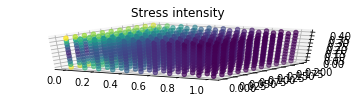

In [143]:
# Plot stress
s = sigma(u) - (1./3)*tr(sigma(u))*Identity(d)  # Deviatoric stress - Principal stress minus the mean of stress - related to 
                                                # shape changes
von_Mises = sqrt(3./2*inner(s, s))              
V = FunctionSpace(mesh, 'P', 1)
von_Mises = project(von_Mises, V)               # Projection of the von Mises function on the space V
plot(von_Mises, title='Stress intensity')       # Plot using FEniCS default function
plt.show()



In [144]:
# Plotting the stress through matplotlib
n = V.dim()                                      # number of dof of the space V                                           
d = mesh.geometry().dim()                        # Dimension of the mesh (same as the method used to retireve the dimension of u)
dof_coordinates = V.tabulate_dof_coordinates()   # Get the coordinates of the degree of freedom of V
dof_coordinates.resize((n, d))                   # Reshape it as a n x d matrix
V0_dofs = V.dofmap().dofs()                      # Getting the order of each degree of freedom
dof_x = dof_coordinates[V0_dofs, :]              # Getting the position vector of each ordered degree of freedom

x = dof_x[:, 0]                                  # Getting the x values of the position of the n dofs
y = dof_x[:, 1]                                  # Getting the y values of the position of the n dofs
z = dof_x[:, 2]                                  # Getting the z values of the position of the n dofs

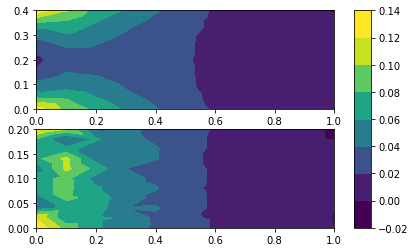

In [145]:
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

xi = np.linspace(0, l_x, 1331)                   # Dimension arrays for interpolation
yi = np.linspace(0, l_y, 1331)                   # Dimension arrays for interpolation
zi = np.linspace(0, l_z, 1331)                   # Dimension arrays for interpolation

gs = gridspec.GridSpec(2, 3, width_ratios=[2, 2, 0.25])

fig = plt.figure()
ax_xz = plt.subplot(gs[0, :2]) # row 0, span all columns
cont = plt.contourf(xi, zi, mlab.griddata(x, z, von_Mises.vector().array(), xi, zi, interp='linear'),vmax=0.12,vmin=0)

ax_xy = plt.subplot(gs[1, :2]) # row 0, col 1
cont = plt.contourf(xi, yi, mlab.griddata(x, y, von_Mises.vector().array(), xi, yi, interp='linear'),vmax=0.12,vmin=0)

ax_cb = plt.subplot(gs[:, 2])
fig.colorbar(cont, cax=ax_cb)
plt.show()

Calling FFC just-in-time (JIT) compiler, this may take some time.
min/max u: -0.000301954933915 0.0684891410776


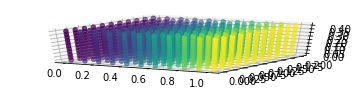

In [146]:
# Compute magnitude of displacement
u_magnitude = sqrt(dot(u, u))                   # l2 norm of the projection
u_magnitude = project(u_magnitude, V)           # Projection of the displacement function on the space V
plot(u_magnitude, 'Displacement magnitude')
print('min/max u:',
u_magnitude.vector().array().min(),
u_magnitude.vector().array().max())
plt.show()

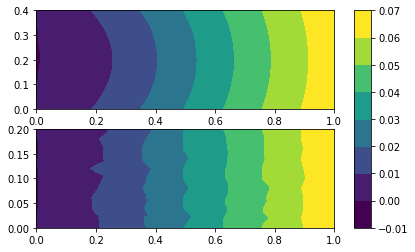

In [147]:
gs = gridspec.GridSpec(2, 3, width_ratios=[2, 2, 0.25])

fig = plt.figure()
ax_xz = plt.subplot(gs[0, :2]) # row 0, span all columns
cont = plt.contourf(xi, zi, mlab.griddata(x, z, u_magnitude.vector().array(), xi, zi, interp='linear'),vmax=0.064,vmin=0)

ax_xy = plt.subplot(gs[1, :2]) # row 0, col 1
cont = plt.contourf(xi, yi, mlab.griddata(x, y, u_magnitude.vector().array(), xi, yi, interp='linear'),vmax=0.064,vmin=0)

ax_cb = plt.subplot(gs[:, 2])
fig.colorbar(cont, cax=ax_cb)
plt.show()